## Capstone 3 - Rossmann Store Sales Prediction

Rossmann operates over 3,000 drug stores in 7 European countries. The Objectives of this project is to analyze Rossmann's store profile and sales data, build a model to predict their daily sales for up to six weeks in advance. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.util.testing as tm
from pandas.plotting import autocorrelation_plot

import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

sns.set_style("whitegrid")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#! pip install -q kaggle

In [6]:
#import os
#os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/24.4 - Capstone 3 - Rossmann Store Sales'

#changing the working directory 
#%cd /content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/24.4 - Capstone 3 - Rossmann Store Sales

# Kaggle API command for the dataset
#! kaggle competitions download -c rossmann-store-sales

In [7]:
#check content in the directory
#!ls

In [8]:
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

## 0) Loading the Dataset

In [9]:
#url to each dataset
store_raw = '/content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/24.4 - Capstone 3 - Rossmann Store Sales/store.csv'
test_raw = '/content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/24.4 - Capstone 3 - Rossmann Store Sales/test.csv'
train_raw = '/content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/24.4 - Capstone 3 - Rossmann Store Sales/train.csv'

In [10]:
# loading the data 
store = pd.read_csv(store_raw, low_memory=False)
train = pd.read_csv(train_raw, parse_dates=['Date'], low_memory=False)
test = pd.read_csv(test_raw, low_memory=False)

In [11]:
# examining the store dataset
print("length/ features :", store.shape)
store.head()

length/ features : (1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [12]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [13]:
# examining the training dataset
print("length/ features :", train.shape)
train.head()

length/ features : (1017209, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


# 1) Understanding the Data & Data Cleaning

In [15]:
# examining missing data
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

Missing data are all in relation to competition profile and promotion profile. Given no conclusion to whether competition is a factor affecting sales, and a store may not run a promotion, these data are retained at the moment. 

In [16]:
train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [17]:
# understanding if the store and train dataframe can potentially be matched up
print('Min/ Max of Store in store dataset :',store['Store'].min(), '/', store['Store'].max())
print('Min/ Max of Store in train dataset :', train['Store'].min(), '/', train['Store'].max())

Min/ Max of Store in store dataset : 1 / 1115
Min/ Max of Store in train dataset : 1 / 1115


1.1) Merging the Store and Train Datasets

In [18]:
dfall = train.merge(store, left_on='Store', right_on='Store')
print("length/ features :", dfall.shape)
dfall.head()

length/ features : (1017209, 18)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


1.2) Checking for Inconsistent Data

In [19]:
#understanding if a sales transaction is really in a promotional period
#true promo is defined as 'Promo2' = True and the 'Promo2SinceYear' not larger than sales transaction year

dfall['Year'] = dfall['Date'].dt.year.astype(int)
dfall['True Promo'] = dfall.apply(lambda x: 1 if ((x['Promo2']==1) & (x['Promo2SinceYear'] <= x['Year'])) else 0, axis=1)

In [20]:
#Sales Recorded in a Store Closed day
sales_at_closeday = dfall[(dfall['Open']==0) & (dfall['Sales']!=0)]
sales_at_closeday

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,True Promo


In [21]:
#checking for duplicate records
duplicated = dfall[dfall.duplicated()]
duplicated

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,True Promo


# 2) Exploratory Data Analysis (EDA) & Visualization




2.1 Understanding Rossmann Store's Sales Data

In [22]:
#understanding the sales data timeframe
print('The sales data has a date range between:', dfall['Date'].min(), '&', dfall['Date'].max())

The sales data has a date range between: 2013-01-01 00:00:00 & 2015-07-31 00:00:00


Text(0, 0.5, 'Store Count (Aggregated)')

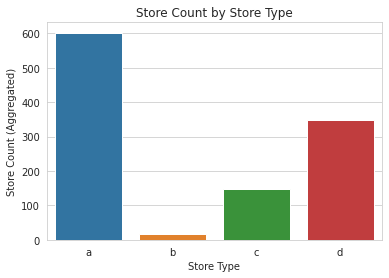

In [23]:
#count of store type
storecount = pd.pivot_table(store,index=['StoreType'],values=['Store'],aggfunc='size').reset_index()
sns.barplot(x='StoreType', y=0, data=storecount)
plt.title('Store Count by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Store Count (Aggregated)')

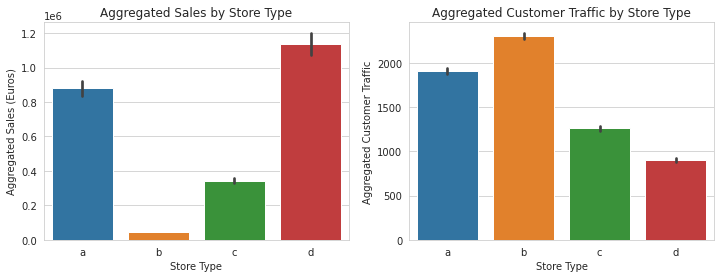

In [24]:
#distribution of store types
storetype = pd.pivot_table(dfall,index=['StoreType', 'Customers'],values=['Sales'],aggfunc=sum).reset_index()

fig, (ax1, ax2) =plt.subplots(1,2, figsize=(12,4))

# Aggregated Sales by store type
sns.barplot(data=storetype, x='StoreType', y='Sales', ax=ax1)
ax1.set_title('Aggregated Sales by Store Type')
ax1.set_xlabel('Store Type')
ax1.set_ylabel('Aggregated Sales (Euros)')

# Aggregated Customer Traffic by store type
sns.barplot(data=storetype, x='StoreType', y='Customers', ax=ax2)
ax2.set_title('Aggregated Customer Traffic by Store Type')
ax2.set_xlabel('Store Type')
ax2.set_ylabel('Aggregated Customer Traffic')
fig.show()

By store type, most stores are either type A or D. The aggregated sales are largely reflective of the store type profiles. However, despite b type stores existed the least, they have driven most of the customer traffic.

Text(0, 0.5, 'Avg. Sales (Euros)')

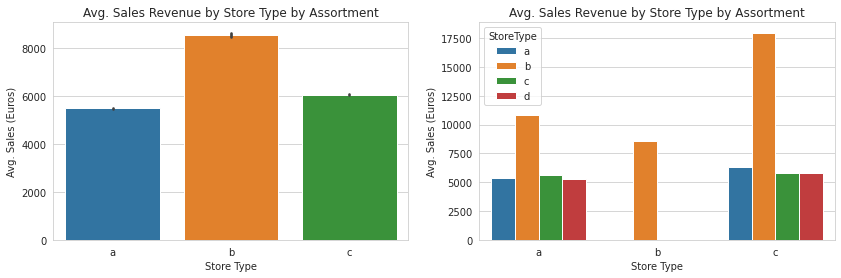

In [25]:
#average sales by store type & assortment
storetype_pivot = pd.pivot_table(dfall,index=['StoreType', 'Assortment'],values=['Sales'],aggfunc=np.mean).reset_index()
storetype_pivot['Sales'] = storetype_pivot['Sales'].round(2)

#creating subplots & order lists
fig, (ax1, ax2) =plt.subplots(1,2, figsize=(14,4))
order_list = ['a', 'b', 'c']

# Total Sales by assortment type
sns.barplot(x='Assortment', y='Sales', data=dfall, order=order_list, ax=ax1)
ax1.set_title('Avg. Sales Revenue by Store Type by Assortment')
ax1.set_xlabel('Store Type')
ax1.set_ylabel('Avg. Sales (Euros)')

# Average sales by assortment & store type
sns.barplot(x='Assortment', y='Sales', hue='StoreType', data=storetype_pivot, order=order_list, ax=ax2)
ax2.set_title('Avg. Sales Revenue by Store Type by Assortment')
ax2.set_xlabel('Store Type')
ax2.set_ylabel('Avg. Sales (Euros)')

A further deep diving into what type of assortment store type B (with most traffic carries), it is the extended assortment with a much wider range. Stores with extended assortment is also driving more sales on average.

In [26]:
#understanding the average value a customer brings
dfall['ATV'] = dfall['Sales']/dfall['Customers']
print('On average, a customer is spending', "%.2f" %(dfall['ATV'].mean()), 'euros per transaction.')

On average, a customer is spending 9.49 euros per transaction.


Text(0, 0.5, 'ATV (Euros)')

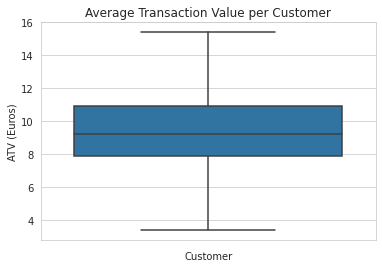

In [27]:
#boxplotting thes sales data per store type
sns.boxplot(y=dfall['ATV'], showfliers = False)
plt.title('Average Transaction Value per Customer')
plt.xlabel('Customer')
plt.ylabel('ATV (Euros)')

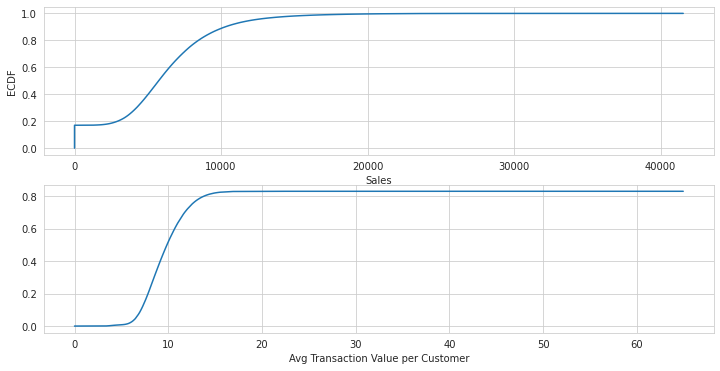

In [28]:
#ECDF diagram for Sales & ATV
plt.figure(figsize = (12, 6))

# plot first ECDF - Sales Figures
plt.subplot(211)
cdf = ECDF(dfall['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF - ATV figures 
plt.subplot(212)
cdf = ECDF(dfall['ATV'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.xlabel('Avg Transaction Value per Customer');

The ECDF plot indicated that around 20% of Sales data are showing zero in value. Store opening patterns will be examined to understand if this is due to stores not in operation.

In [29]:
#Days with store open but with zero sales value
zero_open = dfall[(dfall['Open']==1) & (dfall['Sales']==0)]
print('There are only', zero_open.shape[0], 'records which a store generated zero sales during an opened day.')
print('Accounting to only', "%.2f" %(zero_open.shape[0]/dfall.shape[0]*100), '% of total transaction records, and is negligable.')

There are only 54 records which a store generated zero sales during an opened day.
Accounting to only 0.01 % of total transaction records, and is negligable.


Text(0.5, 1.0, 'Rossmann Store Operating Pattern (Operating)')

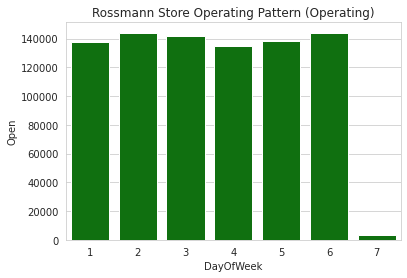

In [30]:
#undertanding store opening pattern
storeopen = pd.pivot_table(dfall,index=['DayOfWeek'],values=['Open'],aggfunc=np.sum).reset_index()
sns.barplot(x='DayOfWeek', y='Open', data=storeopen, color='green')
plt.title('Rossmann Store Operating Pattern (Operating)')

Most stores are not opened on Sundays.

2.2 Understanding If there are Seasonalities to Sales

Text(0.5, 1.0, 'Sales Trend - 2013 to 2015')

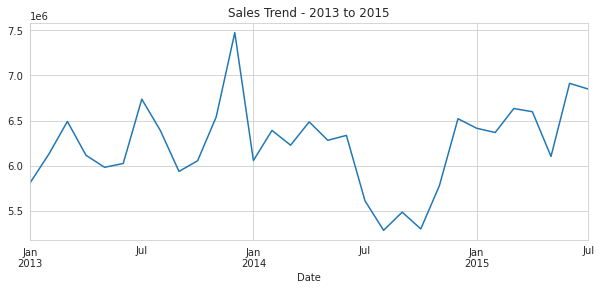

In [31]:
sales_trend = dfall.groupby('Date')['Sales'].sum().reset_index()
sales_trend = sales_trend.set_index('Date')

t = sales_trend['Sales'].resample('MS').mean()
t.plot(figsize=(10, 4))
plt.title('Sales Trend - 2013 to 2015')

The graph indicated that sales did not exponentially grow over the period. 

In [32]:
#randomly select sample from each store type
random_a = dfall[dfall['StoreType'] == 'a'].sample(1)
random_b = dfall[dfall['StoreType'] == 'b'].sample(1)
random_c = dfall[dfall['StoreType'] == 'c'].sample(1)
random_d = dfall[dfall['StoreType'] == 'd'].sample(1)

# retrieving the store number
a = random_a.iloc[0]['Store']
b = random_b.iloc[0]['Store']
c = random_c.iloc[0]['Store']
d = random_d.iloc[0]['Store']

print('Randomied Store number sampled for each store type (a to d):', a, b, c, d)

Randomied Store number sampled for each store type (a to d): 240 274 464 313


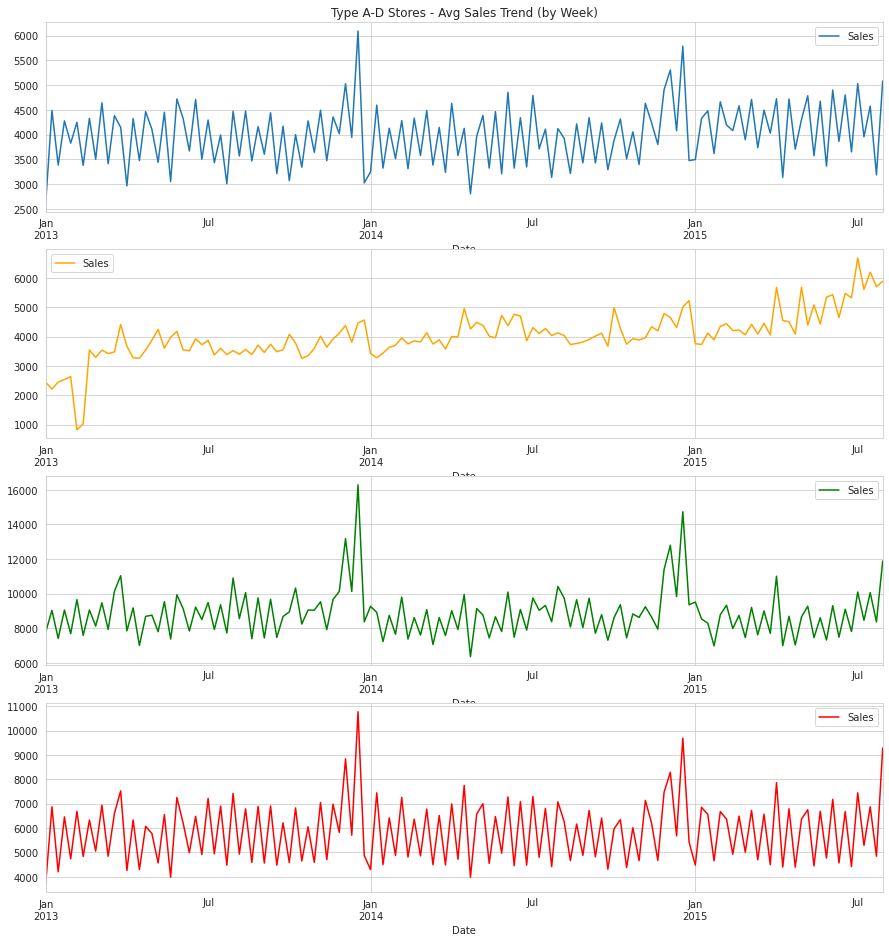

In [33]:
type_a = dfall[dfall['Store'] == a][['Date','Sales']].set_index('Date')
type_b = dfall[dfall['Store'] == b][['Date','Sales']].set_index('Date')
type_c = dfall[dfall['Store'] == c][['Date','Sales']].set_index('Date')
type_d = dfall[dfall['Store'] == d][['Date','Sales']].set_index('Date')

# plotting the seasonality sales trend of the stores by type
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (15, 16))
type_a.resample('W').mean().plot(ax=ax1)
ax1.title.set_text('Type A-D Stores - Avg Sales Trend (by Week)')
type_b.resample('W').mean().plot(ax=ax2, color='orange')
type_c.resample('W').mean().plot(ax=ax3, color='green')
type_d.resample('W').mean().plot(ax=ax4, color='red')

With the exception of Store Type B, all other store types has distinct pattern where sales peaked in Dec, coinciding with the holiday seasons.

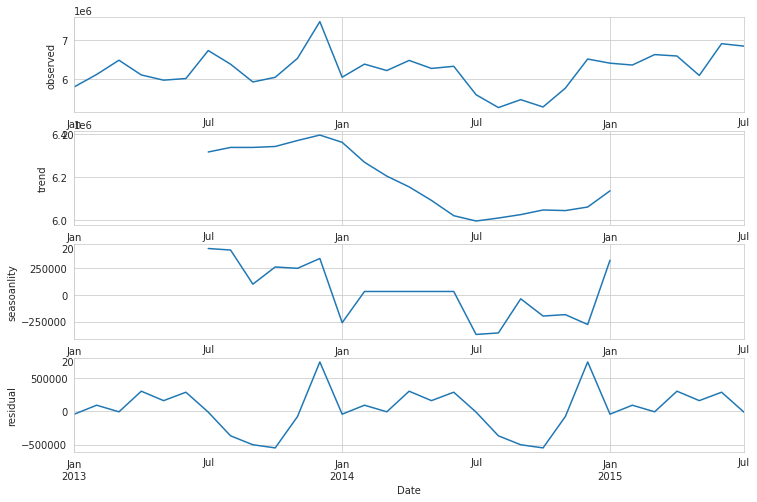

In [34]:
# additive instead of multiplicative is chosen as the model since no exponential increase in sales over time
sea_dec = seasonal_decompose(t, model = "additive")

fig, (ax1, ax2, ax3,ax4) = plt.subplots(4,1, figsize=(12,8))
sea_dec.observed.plot(ax=ax1,ylabel = "observed")
sea_dec.trend.plot(ax=ax2,ylabel = "trend")
sea_dec.resid.plot(ax=ax3,ylabel = "seasoanlity")
sea_dec.seasonal.plot(ax=ax4,ylabel = "residual")
plt.show()

2.3 Understanding Factors driving Store Sales

Text(0.5, 1.0, 'Relationship between Customer Traffic and Sales')

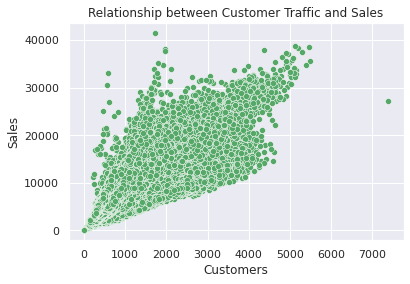

In [35]:
# Relationship between number of customer traffic and sales
sns.set_theme(color_codes=True)
sns.scatterplot(x='Customers', y='Sales', data=dfall, color='g') #regplot for fit line
plt.title('Relationship between Customer Traffic and Sales')

There is a clear pattern that customer traffic is correlated to sales.

Text(0, 0.5, 'Avg Sales')

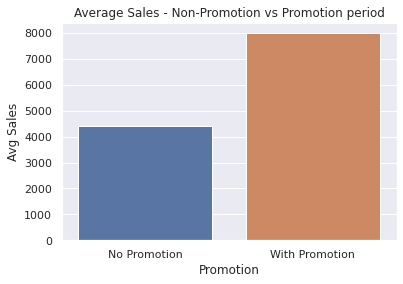

In [36]:
#understanding the impact of promotion to sales
promo_pivot = pd.pivot_table(dfall,index=['Promo'],values=['Sales'],aggfunc=np.mean).reset_index()
promo_pivot['Sales'] = promo_pivot['Sales'].round(2)
promo_pivot['Promo'] = promo_pivot['Promo'].replace({0: 'No Promotion', 1: 'With Promotion'})
sns.barplot(x='Promo', y='Sales', data=promo_pivot) #regplot for fit line
plt.title('Average Sales - Non-Promotion vs Promotion period')
plt.xlabel('Promotion')
plt.ylabel('Avg Sales')

In [37]:
#averge extra sales generated vs non-promotional period
print('On average, average sales value is', "%.2f" %(promo_pivot['Sales'].pct_change()[1]*100), '% more if there is a promotion.')

On average, average sales value is 81.37 % more if there is a promotion.


Text(0, 0.5, 'Avg Customer Traffic')

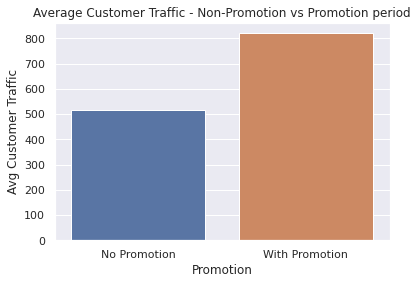

In [38]:
#Are promotions driving customer traffic
promotraffic = pd.pivot_table(dfall,index=['Promo'],values=['Customers'],aggfunc=np.mean).reset_index()
promotraffic['Customers'] = promotraffic['Customers'].round(2)
promotraffic['Promo'] = promotraffic['Promo'].replace({0: 'No Promotion', 1: 'With Promotion'})
sns.barplot(x='Promo', y='Customers', data=promotraffic) #regplot for fit line
plt.title('Average Customer Traffic - Non-Promotion vs Promotion period')
plt.xlabel('Promotion')
plt.ylabel('Avg Customer Traffic')

In [39]:
#averge extra traffic generated vs non-promotional period
print('On average, average customer traffic is', "%.2f" %(promotraffic['Customers'].pct_change()[1]*100), '% more if there is a promotion.')

On average, average customer traffic is 58.38 % more if there is a promotion.


Text(0, 0.5, 'Sales (Euros)')

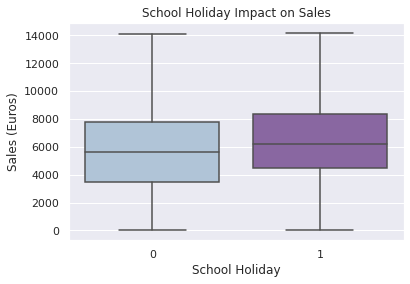

In [40]:
#Understanding the impact on sales on school holidays
sns.boxplot(x='SchoolHoliday', y='Sales', data=dfall, showfliers = False, palette='BuPu')
plt.title('School Holiday Impact on Sales')
plt.xlabel('School Holiday')
plt.ylabel('Sales (Euros)')

Text(0, 0.5, 'Sales (Euros)')

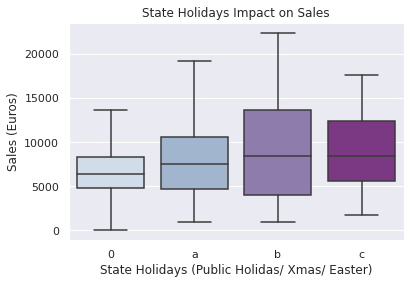

In [41]:
openstatehol = dfall[(dfall['Open']==1) & (dfall['StateHoliday']!=0)]
sns.boxplot(x='StateHoliday', y='Sales', data=openstatehol, showfliers = False, palette='BuPu')
plt.title('State Holidays Impact on Sales')
plt.xlabel('State Holidays (Public Holidas/ Xmas/ Easter)')
plt.ylabel('Sales (Euros)')

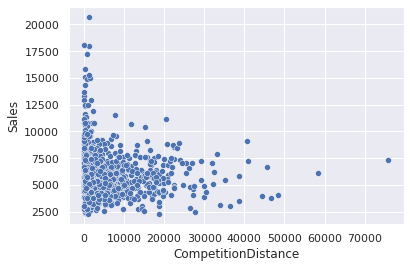

In [42]:
#impact of competition to sales
competition = dfall[dfall['CompetitionDistance'].notnull()]
comp_pivot = pd.pivot_table(competition, index=['Store', 'CompetitionDistance'],values=['Sales'],aggfunc=np.mean).reset_index()
sns.scatterplot(x='CompetitionDistance', y='Sales', data=comp_pivot)

There is no clear pattern how competition is affecting sales.

# 3) Pre-Processing




3.1) Dropping Transaction Records where Stores are Closed

In [43]:
dfall.shape

(1017209, 21)

In [44]:
drop_index = dfall[dfall['Open']==0].index
df_clean = dfall.drop(drop_index)
print('after dropping records where stores are closed:', df_clean.shape)

after dropping records where stores are closed: (844392, 21)


3.2) Extracting Month/ Date Features from Date 

In [45]:
dfall['Month'] = dfall['Date'].dt.month.astype(int)
dfall['Day'] = dfall['Date'].dt.day.astype(int)

3.3) Hot Coding Categorical Data Columns

In [46]:
# Columns which reqires hot coding
df_clean.select_dtypes(include='object').columns

Index(['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval'], dtype='object')

In [47]:
# cleaning the StateHoliday data to only contain string
df_clean['StateHoliday'].replace(0,'0', inplace=True)
df_clean['StateHoliday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [48]:
# labelEncoding StateHoliday, StoreType, Assortment
lbl = preprocessing.LabelEncoder()
df_clean['StateHoliday'] = lbl.fit_transform(df_clean['StateHoliday'].values)
df_clean['StoreType'] = lbl.fit_transform(df_clean['StoreType'].values)
df_clean['Assortment'] = lbl.fit_transform(df_clean['Assortment'].values)

In [49]:
# cleaning the PromoInterval data 
df_clean['PromoInterval'].replace({',':'', np.nan:'0'} , inplace=True)
df_clean['PromoInterval'] = lbl.fit_transform(df_clean['PromoInterval'].values)

3.3) Handling Missing Data

In [50]:
print(df_clean.shape)
print(df_clean.isnull().sum())

(844392, 21)
Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2186
CompetitionOpenSinceMonth    268619
CompetitionOpenSinceYear     268619
Promo2                            0
Promo2SinceWeek              423307
Promo2SinceYear              423307
PromoInterval                     0
Year                              0
True Promo                        0
ATV                              52
dtype: int64


*   ATV - null values will be filled by 0 as the transaction records are also showing 0 sales
*   Competition Distance, OpenSince Month/ Year - will be hanelded using mean or median data
*   Promo2SinceWeek/ Promo2SinceYear Columns, as the other column Promo is already indicating whether the transaction was done with promotion, these 2 columns will eventually be dropped given half of them are missing


In [51]:
# fillna for ATV with 0
df_clean['ATV'].replace(np.nan, 0, inplace=True)

# fillna with mean for Competition Distance, Open Since Month/ Year
df_clean['CompetitionDistance'].replace(np.nan, df_clean['CompetitionDistance'].mean(), inplace=True)
df_clean['CompetitionOpenSinceMonth'].replace(np.nan, df_clean['CompetitionOpenSinceMonth'].mean(), inplace=True)
df_clean['CompetitionOpenSinceYear'].replace(np.nan, df_clean['CompetitionOpenSinceYear'].mean(), inplace=True)

3.4) Feature Engineering

In [52]:
#Time-lagged fatures

# +/= 7 days time lag on sales
df_clean['Sales lag -7'] = df_clean['Sales'].shift(-7).replace(np.nan, 0)
df_clean['Sales lag +7'] = df_clean['Sales'].shift(7).replace(np.nan, 0)

In [53]:
df_clean.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth         0
CompetitionOpenSinceYear          0
Promo2                            0
Promo2SinceWeek              423307
Promo2SinceYear              423307
PromoInterval                     0
Year                              0
True Promo                        0
ATV                               0
Sales lag -7                      0
Sales lag +7                      0
dtype: int64

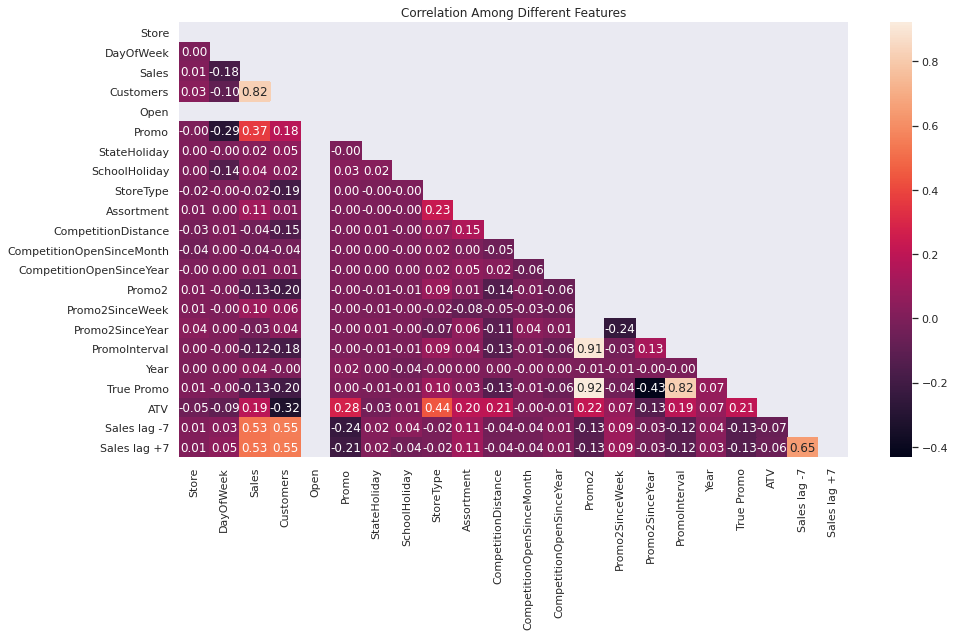

In [54]:
#understanding the correlation between the features
matrix = np.triu(df_clean.corr())
plt.figure(figsize=(15,8))
plt.title('Correlation Among Different Features')
sns.heatmap(df_clean.corr(), annot=True, mask=matrix, fmt=".2f")

3.5) Train/Test Split

In [55]:
#dropping columns CompetitionOpenSinceMonth/Year
df = df_clean.drop(['Promo2SinceWeek', 'Promo2SinceYear', 'Date'], axis=1)

In [56]:
#dropping target variable
features = df.drop(['Sales'], axis=1)

In [57]:
df.shape

(844392, 20)

In [58]:
X = features
y = df['Sales']

In [59]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)

3.6) Examining the Predictive Power of different features & removing Colinearity

In [60]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

In [61]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [62]:
final_iv, IV = data_vars(X_train, y_train)

In [63]:
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X2 = X_train[features]

In [64]:
def iterate_vif(df, vif_threshold=5, max_vif=6):
  count = 0
  while max_vif > vif_threshold:
    count += 1
    print("Iteration # "+str(count))
    vif = pd.DataFrame()
    vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns

    if vif['VIFactor'].max() > vif_threshold:
      print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
      df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
      max_vif = vif['VIFactor'].max()
    else:
      print('Complete')
      return df, vif.sort_values('VIFactor')

final_df, final_vif = iterate_vif(X_train)

Iteration # 1
Removing Open with VIF of 7250452.585617
Iteration # 2
Removing Year with VIF of 165169.769012
Iteration # 3
Removing CompetitionOpenSinceYear with VIF of 55.970977
Iteration # 4
Removing Promo2 with VIF of 25.067301
Iteration # 5
Removing ATV with VIF of 21.931592
Iteration # 6
Removing Sales lag -7 with VIF of 12.289189
Iteration # 7
Removing Sales lag +7 with VIF of 9.603266
Iteration # 8
Removing CompetitionOpenSinceMonth with VIF of 5.875608
Iteration # 9
Removing True Promo with VIF of 5.601929
Iteration # 10
Complete


In [65]:
final_df.head()

,Store,DayOfWeek,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,PromoInterval
227230,251,2,2206,0,0,1,0,2,340.0,0
306185,337,5,457,1,0,0,3,2,10600.0,1
129107,142,2,547,0,0,0,0,0,1090.0,0
608510,668,3,1168,1,0,0,2,0,1270.0,0
172240,191,3,673,1,0,0,0,0,1100.0,2


In [66]:
final_vif.sort_values(by='VIFactor', ascending=False)

,VIFactor,features
2,3.821702,Customers
1,3.739668,DayOfWeek
0,3.418521,Store
7,2.036217,Assortment
3,1.891554,Promo
6,1.858938,StoreType
9,1.759126,PromoInterval
8,1.508662,CompetitionDistance
5,1.225021,SchoolHoliday
4,1.003724,StateHoliday


3.7) Building final features and Train/Test Split

In [67]:
final_features = final_df.columns.tolist()
final_features

['Store',
 'DayOfWeek',
 'Customers',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'PromoInterval']

In [68]:
X = df[final_features]
y = df['Sales']

In [69]:
X.shape, y.shape

((844392, 10), (844392,))

In [70]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)

# 4) Modelling




Several models will be used initially to test the effectiveness in the prediction:<br>


*   Linear Regression
*   Random Forest Regressor





In [71]:
#Linear Regression Model
lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [72]:
#Linear Regression Results
print("Linear Regresion Model Score" , ":" , lr_model.score(X_train, y_train).round(3))
print("RMSE (Testing set)" , ":" , sqrt(mean_squared_error(y_test, y_pred)))

Linear Regresion Model Score : 0.759
RMSE (Testing set) : 1524.0231257177327


In [73]:
#Random Forest Regressor Model
rfr = RandomForestRegressor(n_estimators=10)
rfr_model = rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

In [74]:
#Random Forest Regressor Results
print("Random Forest Regressor Model Score" , ":" , rfr_model.score(X_train, y_train).round(3))
print("RMSE (Testing set)" , ":" , sqrt(mean_squared_error(y_test, y_pred)))

Random Forest Regressor Model Score : 0.993
RMSE (Testing set) : 570.1510876085448


This model's result is indicating an overfitting issue.